In [1]:
### All the packages we need:
%matplotlib inline
%load_ext rpy2.ipython

from Reader import Reader
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from Traj_creator import Traj_data

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

In [2]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data_norm_mult.csv"):
    print "The file existed so I loaded it."
    H2b_n_m = Traj_data(file_name="H2b_data_norm_mult.csv")#,pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b_n_m=Traj_data(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2b_n_m.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
    H2b_n_m.add_error() ## We had it so that the data won't have to do 0/0
    H2b_n_m.Add_traj(normalize=True)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b_n_m.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b_n_m.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b_n_m.data.to_csv('H2b_data_norm_mult.csv',index=False,header=True) 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/naylor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 54.723188 in sec


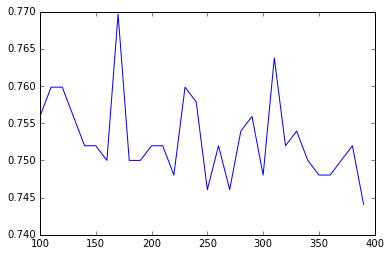

We now have a classifier with n=170, with an expected accuracy of 0.770 for the normalized data. 



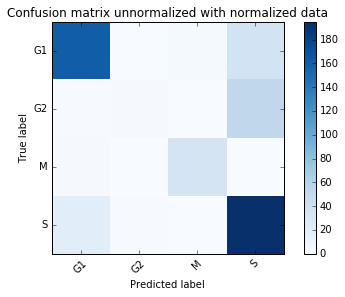

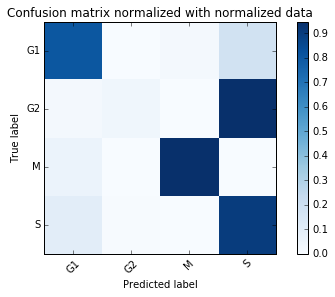

In [3]:

kfold=3

instances_to_keep=pd.notnull(H2b_n_m.data.traj)

H2b_n_m.data=H2b_n_m.data.ix[instances_to_keep,H2b_n_m.data.columns]
H2b_n_m.update()

print "training dataset: \n"
print H2b_n_m.train["Type"].value_counts()

if H2b_n_m.Var_missing[0] in H2b_n_m.train.columns:
    H2b_n_m.missing_features_train()
if H2b_n_m.Var_missing[0] in H2b_n_m.data.columns:
    H2b_n_m.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train[H2b_n_m.names],H2b_n_m.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data")
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data")
plt.show()

Reader constructed
Processing time: 536.026068 in sec


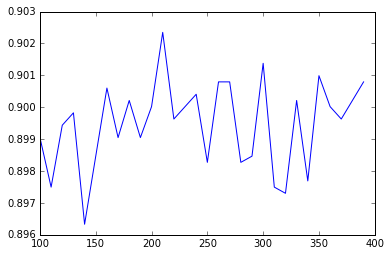

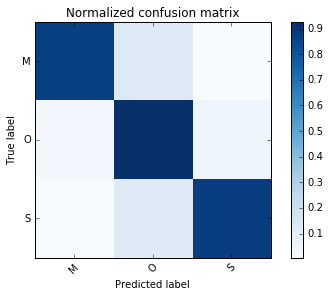

In [4]:
train_file="MitoseClassif.arff"

train_1=Reader()
train_1.arrf_read(train_file)
train_1.renaming_for_mitosis()

train_1.data["label"].value_counts()

kfold=3

if train_1.Var_missing[0] in train_1.data.columns:
    train_1.missing_features_data()
    
values=[100 + i*10 for i in range(30)]
model_1=RandomForest_Autotunner(values)

model_1.tunning(train_1.data[train_1.names],train_1.data["label"],kfold,plot=True,fit_new_model=True)
plt.show()

model_1.cm_normalized = model_1.cm.astype('float') / model_1.cm.sum(axis=1)[:, np.newaxis]

plot_matrix(model_1.cm_normalized,title="Normalized confusion matrix",names=["M","O","S"])
plt.show()



In [5]:
## To reduce computation and none useless things, we remove instances that do not belong to trajectories.

index_traj=pd.notnull(H2b_n_m.data["traj"])
H2b_n_m.data=H2b_n_m.data.ix[index_traj,H2b_n_m.data.columns]
H2b.data=H2b.data.ix[index_traj,H2b.data.columns]

H2b_n_m.update()
H2b.update()
## Predicting model 1

index_no_missing=H2b_n_m.data[H2b_n_m.names].dropna(axis=0, how='any').index
H2b_n_m.data.ix[index_no_missing,"MitoseOrNot"]=model_1.predict(H2b.data.ix[index_no_missing,train_1.names]) 
## Carefull, we put the unnormalized data in the above prediction.

print "Frequency of predicted values for the Mitosis or not classifier: \n"
print H2b_n_m.data["MitoseOrNot"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b_n_m.data.shape[0]-len(index_no_missing))

H2b_n_m.data

H2b_n_m.update()

##We have to retrain the model for the normalized version as this one was trained with the class M

index_no_M=H2b_n_m.data["Type"]!="M"

print "training dataset: \n"
print H2b_n_m.train.ix[index_no_M,"Type"].value_counts()


values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train.ix[index_no_M,H2b_n_m.names],H2b_n_m.train.ix[index_no_M,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))

model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Normalized confusion matrix",names=["G1","G2","S"])
plt.show()

H2b_n_m.data.ix[index_no_missing,"3State"]=model_n_m.predict(H2b_n_m.data.ix[index_no_missing,H2b_n_m.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"3State"].value_counts()




NameError: name 'H2b' is not defined

In [ ]:
### Giving priority to the first classif...
def f(value_1,value_2):
    if value_1=="M":
        return(value_1)
    else:
        return(value_2)
H2b_n_m.data["Pred_Fusion"]=H2b_n_m.data.apply(lambda r: f(r["MitoseOrNot"],r["3State"]),axis=1)

print "Frequency of predicted values for the 4 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"Pred_Fusion"].value_counts()
H2b_n_m.update()

##First we are going to seperate beginning M's and ending M's
for i in range(len(H2b_n_m.trajectories)):
    new_obs=np.array(H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"])
    n_obs=len(new_obs)
    for j in range(n_obs/2):
        if new_obs[j]=='M':
            new_obs[j]='B'  #Beginning
    H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"]=new_obs
H2b_n_m.data.ix[H2b_n_m.data["Pred_Fusion"]=='M',"Pred_Fusion"]='E' #Ending


X3=model_n_m.cm_normalized
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T

EmissionMat=np.zeros(shape=(5,5))
EmissionMat[0,0]=model_1.cm_normalized[0,0]
EmissionMat[4,4]=model_1.cm_normalized[0,0]
EmissionMat[1:5,0]=(1-model_1.cm_normalized[0,0])/3
EmissionMat[0:4,4]=(1-model_1.cm_normalized[0,0])/3

### Bricolage

EmissionMat[1:4,1:4]=X3
EmissionMat[1:4,1:3]+=-EmissionMat[3,0]*2/3

### On modifie car la diag n'est pas assez bonne...
EmissionMat[3,2:4]=[0.4,0.5]

EmissionMat[0,1:4]=sum(model_1.cm_normalized[0,1:3])/3
EmissionMat[4,1:4]=sum(model_1.cm_normalized[0,1:3])/3

EmissionMat=abs(EmissionMat).astype('float') / abs(EmissionMat).sum(axis=1)[:, np.newaxis]
## Put something better then abs... 

plot_matrix(EmissionMat,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()

H2b_n_m.data=H2b_n_m.data.sort_values(['traj', num_str+"_id_frame"], ascending=[1, 1])

data=H2b_n_m.data.ix[pd.notnull(H2b_n_m.data["traj"]),["traj","Pred_Fusion"]]


data.ix[data.Pred_Fusion=='2',"Pred_Fusion"]="4"
data.ix[data.Pred_Fusion=='1',"Pred_Fusion"]="2"
data.ix[data.Pred_Fusion=='B',"Pred_Fusion"]="1"
data.ix[data.Pred_Fusion=='E',"Pred_Fusion"]="5"
data.ix[data.Pred_Fusion=='S',"Pred_Fusion"]="3"

%Rpush EmissionMat
%Rpush data 

In [ ]:
%%R 
source("HMM_correcting_model.R")
HMM_correct(data,EmissionMat,"Pred_Fusion",obs_number=0)